In [1]:
#Performs high-pass and low-pass filtering on provided data
#Filtered data has cutoffs of default 10 days; other cut-offs are 6 and 8
#15 days will be chopped off the beginning and the end of input dataset, so include 15 extra days on either end.

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

stime=time.time()

In [3]:
#Filter function
#length: number of coefficients
#t: time step
#s_t: time series
#b: coefficients
#cut: filter-cutoff (default 10, others are 6, 8, 12)
#returns filtered time series
def filt(length, t, s_t, b, cut=10):
    fil = 0
    
    index = np.arange(-length,length+1)
    
    for coeff in index:
        #fil += s_t[t+coeff,:,:,:] * b.sel(cutoffs=cut,coefficients=coeff)
        fil += s_t[t+coeff,:,:] * b.sel(cutoffs=cut,coefficients=coeff)

    return fil

In [5]:
#Filter coeff file
#File name
path_filt_in = '~/metisregimes/'
namein = 'lowpasscoef_twicedaily.nc'
filein = path_filt_in+namein

#Filter cutoff: default 10, other choices are 6,8, and 12
cut_at = 10
variable = 'z500'

#Output files
pathin = '/glade/work/mkorendy/metisregimes/tco1279/'
#pathin = '/glade/work/mkorendy/metisregimes/'
#hp_file = 'metis.' + variable + '_pna_NDJFM_hpfilter_twicedaily_' + str(cut_at) + 'days.1986-2016.nc'
#lp_file = 'metis.' + variable + '_pna_NDJFM_lpfilter_twicedaily_' + str(cut_at) + 'days.1986-2016.nc'
hp_file = 'metis.' + variable + '_pna_ND_hpfilter_twicedaily_' + str(cut_at) + 'days.1986-2016.nc'
lp_file = 'metis.' + variable + '_pna_ND_lpfilter_twicedaily_' + str(cut_at) + 'days.1986-2016.nc'
file_out_hp = pathin+hp_file
file_out_lp = pathin+lp_file

print(hp_file)
print(lp_file)

#Dataset in
#series_fname = 'era5.' + variable + '_pna_NDJFM_twicedaily.1986-2016.nc'
#series_fname = 'metis.' + variable + '_pna_NDJFM_.1986-2016.nc'
series_fname = 'metis.' + variable + '_pna_ND_.1986-2016.nc'
print(series_fname)

metis.z500_pna_ND_hpfilter_twicedaily_10days.1986-2016.nc
metis.z500_pna_ND_lpfilter_twicedaily_10days.1986-2016.nc
metis.z500_pna_ND_.1986-2016.nc


In [6]:
#read lowpass filter coefficients in
lowp = xr.open_dataset(filein, decode_times=True, engine='netcdf4')
lowp = lowp['lowpass']

In [7]:
#adjust for highpass filter coefficients
hpcoeff = -lowp

#cutoffs
num_cut = hpcoeff['cutoffs']

#fix middle coefficient of high-pass filter
for i in num_cut:
    hpcoeff.loc[dict(cutoffs=i,coefficients=0)] = 1.0 - lowp.sel(cutoffs=i,coefficients=0)

In [8]:
#READ TIME SERIES IN
ds=xr.open_dataset(pathin+series_fname,decode_times=True)

#PUT DATA IN CONSECUTIVE ORDER
#ds=ds.reindex(time=sorted(ds['time'].values))
ds = ds.transpose('time', 'ensemble', 'lat', 'lon')
print(ds)

<xarray.Dataset>
Dimensions:  (ensemble: 15, lat: 22, lon: 53, time: 3690)
Coordinates:
  * lat      (lat) float64 20.93 23.72 26.51 29.3 ... 71.16 73.95 76.74 79.53
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * time     (time) datetime64[ns] 1986-11-01 1986-11-01T12:00:00 ... 2016-01-01
Dimensions without coordinates: ensemble
Data variables:
    z500     (time, ensemble, lat, lon) float32 ...


In [9]:
#test = ds.sel(time=slice(start_date, pd.to_datetime(str(year-1) + '1101')+pd.DateOffset(days=150)
                               #+ pd.DateOffset(hours=12)) )
#test.time.values
#print(np.arange(1981,1983))

In [25]:
#Filtering over two years! (For one point)
#Determines list of timestamps

#Set list of years
#First year listed should be initial year + 1 as code will subtract 1 from the year
#yrs_list = np.arange(1987,2017)
yrs_list = np.arange(1987,1988)
#yrs_list = np.arange(2016,2017)

#Create empty lists to hold results of filters
hpfilter = []
lpfilter = []

#Empty list of timestamps
filter_times = []

for year in yrs_list:
    
    #Indicate the period of data to be filtered: December 1st - 7.5days, to December 1st + 91 days + 7.5 days
    #Indicate the period of data to be filtered: November 1st to November 1st + 150.5 days
    start_date = pd.to_datetime(str(year-1) + '1101')
    #period = ds.sel(time=slice(start_date, pd.to_datetime(str(year-1) + '1101')+pd.DateOffset(days=150)
    #                           + pd.DateOffset(hours=12)) )
    
    #Indicate the period of data to be filtered: November 1st to December 31st + .5 days
    period = ds.sel(time=slice(start_date, pd.to_datetime(str(year-1) + '1231') + pd.DateOffset(hours=12)) )
    
    #Iterate through lats and longs
    period = period[variable]
    
    #Apply filter to time series
    #Determine range of indices for series: arange((no.coeffs - 1)/2, no.series - (no.coeffs-1)/2)
    coeff_number = (len(hpcoeff['coefficients'])-1)/2
    coeff_number = int(coeff_number)

    #length of time series:
    duration = len(period['time'])
    winter = np.arange(coeff_number,duration-coeff_number)
    print(duration)
    
    #iterate through the whole time series of a year:
    for time in winter:
        hpfilter.append(filt(coeff_number,time,period,hpcoeff,cut=cut_at))
        lpfilter.append(filt(coeff_number,time,period,lowp,cut=cut_at))
    
    #Timestamps associated:
    #filter_start = start_date + pd.DateOffset(days=15)
    #filter_end = start_date + pd.DateOffset(days=91+15)
    
    #filter_start=start_date + pd.DateOffset(days=7) + pd.DateOffset(hours=12)
    #filter_end= start_date + pd.DateOffset(days=91+7)
    
    filter_start=start_date + pd.DateOffset(days=7) + pd.DateOffset(hours=12)
    filter_end= pd.to_datetime(str(year-1) + '1231') - pd.DateOffset(days=7) 
    filter_times.append(pd.date_range(start=filter_start,end=filter_end,freq='12H'))

122


In [26]:
filter_times

[DatetimeIndex(['1986-11-08 12:00:00', '1986-11-09 00:00:00',
                '1986-11-09 12:00:00', '1986-11-10 00:00:00',
                '1986-11-10 12:00:00', '1986-11-11 00:00:00',
                '1986-11-11 12:00:00', '1986-11-12 00:00:00',
                '1986-11-12 12:00:00', '1986-11-13 00:00:00',
                '1986-11-13 12:00:00', '1986-11-14 00:00:00',
                '1986-11-14 12:00:00', '1986-11-15 00:00:00',
                '1986-11-15 12:00:00', '1986-11-16 00:00:00',
                '1986-11-16 12:00:00', '1986-11-17 00:00:00',
                '1986-11-17 12:00:00', '1986-11-18 00:00:00',
                '1986-11-18 12:00:00', '1986-11-19 00:00:00',
                '1986-11-19 12:00:00', '1986-11-20 00:00:00',
                '1986-11-20 12:00:00', '1986-11-21 00:00:00',
                '1986-11-21 12:00:00', '1986-11-22 00:00:00',
                '1986-11-22 12:00:00', '1986-11-23 00:00:00',
                '1986-11-23 12:00:00', '1986-11-24 00:00:00',
        

In [27]:
#Convert filtered data lists into arrays
hp_final = np.array(hpfilter)
lp_final = np.array(lpfilter)

#Convert filtered date-time stamps list into 1D array
times_filtered = np.array(filter_times)
times_filtered = times_filtered.flatten()

In [28]:
print(hp_final.shape)
print(times_filtered.shape)
#print(times_filtered)

(92, 15, 22, 53)
(92,)


In [29]:
#Create datasets of high_pass and low_pass filtered data
high_pass = xr.DataArray(hp_final, coords={'time':times_filtered, 'ensemble':ds['ensemble'].values,
                                           'lat':ds['lat'].values, 'lon':ds['lon'].values},
                        dims=['time','ensemble','lat','lon']).to_dataset(name='high_pass_' + variable)
low_pass = xr.DataArray(lp_final, coords={'time':times_filtered, 'ensemble':ds['ensemble'].values,
                                          'lat':ds['lat'].values, 'lon':ds['lon'].values},
                        dims=['time','ensemble','lat','lon']).to_dataset(name='low_pass_' + variable)

#high_pass = xr.DataArray(hp_final, coords={'time':times_filtered,
#                                           'lat':ds['lat'].values, 'lon':ds['lon'].values},
#                        dims=['time','lat','lon']).to_dataset(name='high_pass_' + variable)

#low_pass = xr.DataArray(lp_final, coords={'time':times_filtered,
#                                          'lat':ds['lat'].values, 'lon':ds['lon'].values},
#                        dims=['time','lat','lon']).to_dataset(name='low_pass_' + variable)
print(high_pass)
print(low_pass)

<xarray.Dataset>
Dimensions:         (ensemble: 15, lat: 22, lon: 53, time: 92)
Coordinates:
  * time            (time) datetime64[ns] 1986-11-08T12:00:00 ... 1986-12-24
  * ensemble        (ensemble) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * lat             (lat) float64 20.93 23.72 26.51 29.3 ... 73.95 76.74 79.53
  * lon             (lon) float64 151.9 154.7 157.5 160.3 ... 292.5 295.3 298.1
Data variables:
    high_pass_z500  (time, ensemble, lat, lon) float64 -35.12 -37.83 ... 232.1
<xarray.Dataset>
Dimensions:        (ensemble: 15, lat: 22, lon: 53, time: 92)
Coordinates:
  * time           (time) datetime64[ns] 1986-11-08T12:00:00 ... 1986-12-24
  * ensemble       (ensemble) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * lat            (lat) float64 20.93 23.72 26.51 29.3 ... 73.95 76.74 79.53
  * lon            (lon) float64 151.9 154.7 157.5 160.3 ... 292.5 295.3 298.1
Data variables:
    low_pass_z500  (time, ensemble, lat, lon) float64 5.789e+04 ... 4.944e+04


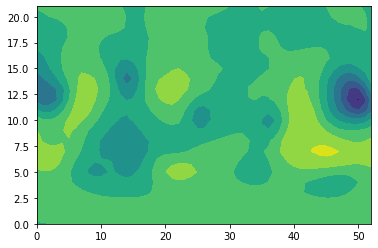

In [31]:
plt.contourf(high_pass['high_pass_' + variable][9,0,::-1,:])
#plt.contourf(high_pass['high_pass_' + variable][123,::-1,:])

<xarray.DataArray 'z500' (time: 3690, ensemble: 15, lat: 22, lon: 53)>
[64538100 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 20.93 23.72 26.51 29.3 ... 71.16 73.95 76.74 79.53
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * time     (time) datetime64[ns] 1986-11-01 1986-11-01T12:00:00 ... 2016-01-01
Dimensions without coordinates: ensemble


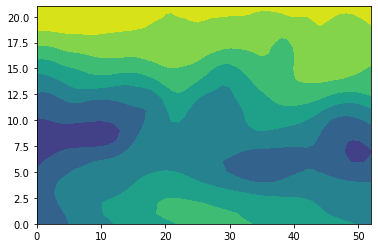

In [32]:
plt.contourf(ds[variable][90,0,::-1,:])
#plt.contourf(ds[variable][288,::-1,:])
print(ds[variable])

In [33]:
#Send datasets to file
high_pass.to_netcdf(file_out_hp)
low_pass.to_netcdf(file_out_lp)

In [34]:
#etime=time.time()
#print(etime - stime)

Text(0.5, 1.0, 'HighPass Filter for first 91 Days')

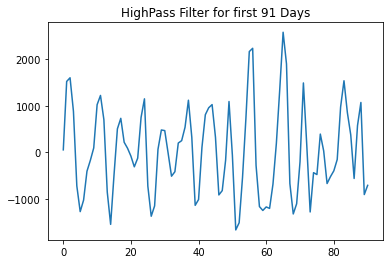

In [35]:
plt.plot(high_pass['high_pass_' + variable][:91,0,10,10])
#plt.plot(high_pass['high_pass_' + variable][:91,10,10])
plt.title('HighPass Filter for first 91 Days')

Text(0.5, 1.0, 'LowPass Filter for first 91 days')

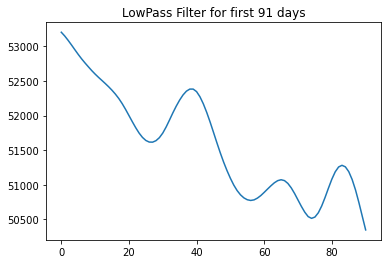

In [36]:
plt.plot(low_pass['low_pass_' + variable][:91,0,10,10])
#plt.plot(low_pass['low_pass_' + variable][:91,10,10])
plt.title('LowPass Filter for first 91 days')

In [37]:
test = ds[variable] - high_pass['high_pass_' + variable]

Text(0.5, 1.0, 'Data - HighPass Filter for first 91 days')

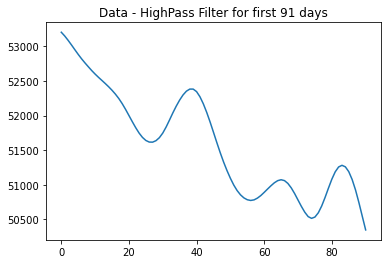

In [38]:
plt.plot(test[:91,0,10,10])
#plt.plot(test[:91,10,10])
plt.title('Data - HighPass Filter for first 91 days')

Text(0.5, 1.0, 'Data for first 91 days')

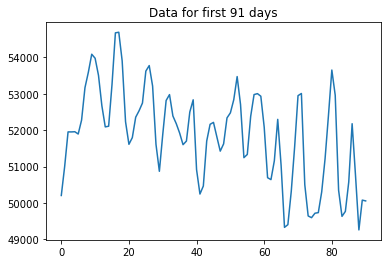

In [39]:
plt.plot(ds[variable][:91,0,10,10])
#plt.plot(ds[variable][:91,10,10])
plt.title('Data for first 91 days')